In [ ]:
import os
import struct
import numpy as np
from matplotlib import pyplot

import matplotlib as mpl
import random
import matplotlib.pyplot as plt
import csv

# some utilities
class_names = list(map(str, range(10)))


def create_submission_file(fname, preds):
    """
    Create Kaggle submision with predictions written as a csv (comma separated values) file
    """

    ofile = open(fname, "w")
    writer = csv.writer(ofile, delimiter=",", quotechar='"', quoting=csv.QUOTE_ALL)

    writer.writerow(["id", "category"])

    for i in range(preds.shape[0]):
        writer.writerow([i, preds[i]])


def read_MNIST(dataset="training", path="data", load_small=False):
    """
    reading in the "MNIST" data
    this function allows specification of the part to be read (training/testing/validation)
    if load_small = True, this will look for the file(s) associated with the small training set
    Note that if dataset='testing', no labels will be returned
    """

    # Figure out the name of the file to load
    if dataset.lower() == "training":
        file_name_suffix = "Tr"
        has_labels = True

    elif dataset.lower() == "validation":
        file_name_suffix = "Vl"
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = "Te"
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError

    if load_small:
        file_name_suffix += "_sm"

    # Load the appropriate files
    X_path = os.path.join(path, f"x{file_name_suffix}.npy")
    X = np.load(X_path)
    if has_labels:
        y_path = os.path.join(path, f"y{file_name_suffix}.npy")
        y = np.load(y_path)

    # Return the appropriate data
    if has_labels:
        return X, y
    else:
        return X


def show_MNIST_example(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    image = image[-(28 ** 2) :]
    image = image.reshape(28, 28)

    fig = pyplot.figure()
    ax = fig.add_subplot(1, 1, 1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation("nearest")
    ax.xaxis.set_ticks_position("top")
    ax.yaxis.set_ticks_position("left")
    pyplot.axis("off")
    pyplot.show()

# set random seed for reproducibility    
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

from matplotlib.ticker import FuncFormatter, MaxNLocator

#Get the names for the tickmarks of the confusion matrix
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(10):
        return class_names[int(tick_val)]
    else:
        return ''

def build_confusion_matrix(y_hat,y):
    conf_mat = np.zeros((10,10))
    
    for i in range(10):
        for j in range(10):
            #Put the number of datapoints that had class i, and predicted class j in that entry of conf matrix
            conf_mat[i,j] = np.sum(np.equal(y,i).astype(np.float32)*np.equal(y_hat,j).astype(np.float32))
    
    for i in range(10):
        #normalize all the rows to sum to 1
        conf_mat[i,:] = conf_mat[i,:]/np.sum(conf_mat[i,:])
    
    #Make plot and add tick for each class
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    plt.xticks(range(10))
    plt.yticks(range(10))

    #add labels and display matrix
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    ax.imshow(conf_mat)
    plt.show()
    
    return conf_mat

## Model
Now we will build the code for our softmax model


## <span style="color:blue">Coding 1</span>
function `log_likelihood`: calculation of log-likelihood

## <span style="color:blue">Coding 2</span>
function `gradient`: calculation of the gradient of the regularized objective


In [ ]:
def softmax(scores):
    """
    takes the softmax along the second dimension of a matrix, returns class scores
    """
    # we will adjust the dynamic range by subtracting the max, to prevent potential underflow in exp
    exp_scores = np.exp(scores-np.max(scores,axis=1,keepdims=True))+1e-6
    return exp_scores/(np.sum(exp_scores,axis=1,keepdims=True))


def log_likelihood(X,w,y):
    """
    Inputs: 
      X: a Nxd matrix where each of the N rows is a datapoint with d features
      Y: a Nx10 matrix, each row is a one-hot vector where the ith entry is 1 if that datapoint belongs to class i 
      w: is a dxC matrix containing your model parameters
    Outputs:
      LL: a scalar containing the AVERAGE log-likelihood of the dataset's labels y, given inputs X and model w
    """
    #compute the un-normalized 'scores' of each class for each datapoint
    scores = np.dot(X,w)
    
    #normalize the scores to get a distribution over classes for each datapoint
    predictions = softmax(scores)
        
    #use the predicted distributions and the true distributions to compute log-likelihood
    LL = np.average(np.squeeze(np.log(np.sum(np.multiply(y,predictions),axis=1))))

    return LL

def objective(X,w,y):
    """
    Compute components of the optimization objective
    Output:
    logloss : value of log-loss (negative average log-likelihood)
    regularizer: value of the regularization term (squared Frobenius norm of w), NOT multiplied by lambda
    """
    regularizer = np.linalg.norm(w,'fro') ** 2
    logloss = - log_likelihood(X,w,y)
    return logloss, regularizer


def gradient(X,w,y):
    """
    Compute in grad the gradient of the log-loss of the model (w) given the features (X) and labels (y) w.r.t. w
    Also compute and return in l2grad the gradient of the regularizer lambda*sqnorm(w)
    Note: we can't use the name 'lambda' since it's a keyword in Python
    Reminder: the full objective is -log p(y|X;w) + lmbda*sqnorm2(w)
    """
    
    # Compute any extra variable needed to compute the gradient:
    scores = np.dot(X,w)
    predictions = softmax(scores)

    # Compute the gradient of the average log-loss
    gradI = np.zeros_like(np.transpose(w))
    grad = np.zeros_like(np.transpose(w))
    for n in range(len(y)): #for each training example
        for i in range(len(grad)): #for each row of weight matrix (10)
            gradI[i,:] = (np.log(predictions[n,i]))*X[n]
        gradI[np.argmax(y[n]),:] -= X[n]
        grad += gradI
    
    grad = np.transpose(grad)
    
    # Compute the gradient of the regularization term
    l2grad = 2*w
    
    return grad, l2grad


def infer(X,w):
    """
    Compute the class scores that model w gives for each class, given data X
    """
    scores = np.dot(X,w)
    return scores

def accuracy(X,w,y):
    """
    Compute accuracy (one minus average 0/1 loss) of model w relative to true labels y on data X
    """
    y_hat = np.argmax(infer(X,w),axis=1)
    y = np.argmax(y,axis=1)
    acc = np.sum(np.equal(y,y_hat).astype(np.float32))/y.shape[0]
    return acc

## Optimization
Now we define the SGD (stochastic gradient descent) procedure for softmax, with optional regularization

In [ ]:
def minibatch_sgd(
    xTr, yTr, xVl, yVl, lmbda=0, lr=0.01, maxepochs=10, bsize=32, objTol=0.01, verbose=1
):
    # initialization of w (feel free to play with this)
    w = np.zeros((xTr.shape[1], yTr.shape[1]))

    old_obj = 1e9
    old_w = w

    # we will organize the run in terms of epochs (one epoch = one full pass over data)
    # to keep track of learning curves, allocate space
    trAcc = np.zeros(maxepochs)
    obj = np.zeros(maxepochs)

    for epoch in range(maxepochs):

        # shuffle the data
        index = np.random.permutation(xTr.shape[0])
        batch_starts = range(
            0, xTr.shape[0], bsize
        )  # ignore the remainder N-floor(N/bsize), for simplicity

        for start_index in batch_starts:
            # fill in the batch
            iBatch = index[start_index : start_index + bsize]
            xBatch = xTr[iBatch]
            yBatch = yTr[iBatch]

            grad, l2grad = gradient(xBatch, w, yBatch)

            w = w - lr * (grad + lmbda * l2grad)

        # end of an epoch: test for convergence by looking at validation
        logloss, regularizer = objective(xTr, w, yTr)
        obj[epoch] = logloss + lmbda * regularizer
        # also record accuracy on training
        trAcc[epoch] = accuracy(xTr, w, yTr)

        obj_gain = (old_obj - obj[epoch]) / np.abs(
            old_obj
        )  # improvement in training objective this epoch

        if verbose > 0.5:
            print(
                f"Epoch {epoch:d}: obj={obj[epoch]:.4f}, gain {obj_gain:.4f}  [train acc {trAcc[epoch]:.4f}]"
            )

        if epoch == maxepochs - 1:
            if verbose > 0:
                print("Reached max epochs, stopping")
            return w, obj, trAcc

        if obj_gain < objTol:
            lr = lr / 2
            if verbose > 0:
                print(f"Dropping learning rate to {lr:.4f}")

        # update bookkeeping before going to next epoch
        old_obj = obj[epoch]

## Data: preprocess
Before we can start experiments, we need one more piece: feature transform. In this case we are using the "raw" features (pixel values) plus the constant term, but with normalization that applies z-scoring to each pixel.

In [ ]:
# if mu and sigma are provided, they are used to normalize each pixel
# otherwise, they are computed and returned
def preprocess_data(X, mu=None, sigma=None, visualize=False):

    if visualize:
        print("VISUALIZE BEFORE NORMALIZATION")
        # Visualize example before normalization
        show_MNIST_example(X[300])
        show_MNIST_example(X[500])

    if mu is None:  # need to compute normalizing stats
        compute_stats = True
        mu = X.mean(axis=0, keepdims=True)
        sigma = X.std(axis=0, keepdims=True)
        sigma[
            np.equal(sigma, 0)
        ] = 1.0  # avoid division by zero in case of degenerate features
    else:
        compute_stats = False

    # Normalize the data
    X = (X - mu) / sigma
    bias_feature = np.ones((X.shape[0], 1))
    X = np.concatenate([np.ones((X.shape[0], 1)), X], 1)

    if visualize:
        print("VISUALIZE AFTER NORMALIZATION")
        # Visualize example after normalization
        show_MNIST_example(X[300])
        show_MNIST_example(X[500])

    if compute_stats:
        return X, mu, sigma
    else:
        return X

Let's look at some images

Training images
0 ... 255
VISUALIZE BEFORE NORMALIZATION


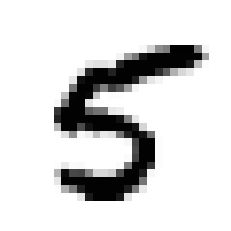

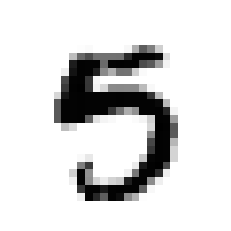

VISUALIZE AFTER NORMALIZATION


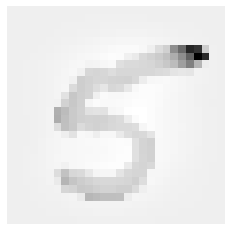

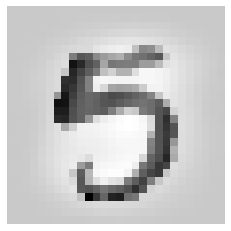

In [ ]:
xTr, yTr = read_MNIST("Training")
print("Training images")
print(f"{np.min(xTr[1])} ... {np.max(xTr[1])}")

xTr, mu, sigma = preprocess_data(xTr, visualize=True)

## Experiment

We now define the main routine for our experiments: load training/validation data sets, and tune the regularization parameter (and perhaps other parameters you want to tune)

In [ ]:
# run minibatch SGD for every value of lambda and record training/val accuracy
def tune_regularization(xTr, yTr, xVl, yVl, lambdas, sgd_opt):

    obj = dict()
    trAcc = dict()
    model = dict()
    valAcc = dict()

    for lmbda in lambdas:
        model[lmbda], obj[lmbda], trAcc[lmbda] = minibatch_sgd(
            xTr,
            yTr,
            xVl,
            yVl,
            lmbda,
            sgd_opt["lr"],
            sgd_opt["maxepochs"],
            sgd_opt["bsize"],
            verbose=sgd_opt["verbose"],
        )
        valAcc[lmbda] = accuracy(xVl, model[lmbda], yVl)
        if sgd_opt["verbose"] >= 0:
            print(
                f"-------------- lambda={lmbda:.5f}, val Acc = {valAcc[lmbda]:.4f}  (tr Acc = {trAcc[lmbda][-1]:.4f})"
            )

    return model, obj, trAcc, valAcc

---
## Experiment 1: full training set
---

## <span style="color:blue">Coding 3.1</span>
selection of the model based on a sweep over values of $\lambda$ (for full datasets).

In [ ]:
xTr, yTr = read_MNIST("Training")
xVl, yVl = read_MNIST("Validation")

xTr, mu, sigma = preprocess_data(xTr, visualize=False)
xVl = preprocess_data(xVl, mu, sigma, visualize=False)

lambdas = [10.0]

sgd_opt = {"bsize": 16, "maxepochs": 40, "lr": 0.1, "verbose": 1}

seed = 0
set_seed(seed)

model, obj, trAcc, valAcc = tune_regularization(xTr, yTr, xVl, yVl, lambdas, sgd_opt)

# Add your code to select the best model here
print(valAcc)
best=10

Epoch 0: obj=99882140829.2384, gain -98.8821  [train acc 0.0544]
Dropping learning rate to 0.0500
Epoch 1: obj=2440455.6443, gain 1.0000  [train acc 0.0881]
Epoch 2: obj=399027.4345, gain 0.8365  [train acc 0.1431]
Epoch 3: obj=328883.6470, gain 0.1758  [train acc 0.0597]
Epoch 4: obj=283915.0198, gain 0.1367  [train acc 0.1879]
Epoch 5: obj=420271.5732, gain -0.4803  [train acc 0.0927]
Dropping learning rate to 0.0250
Epoch 6: obj=119943.2694, gain 0.7146  [train acc 0.1311]
Epoch 7: obj=351209.6196, gain -1.9281  [train acc 0.1636]
Dropping learning rate to 0.0125
Epoch 8: obj=56934.2787, gain 0.8379  [train acc 0.1426]
Epoch 9: obj=60699.7331, gain -0.0661  [train acc 0.1306]
Dropping learning rate to 0.0063
Epoch 10: obj=39534.2620, gain 0.3487  [train acc 0.1316]
Epoch 11: obj=30480.6770, gain 0.2290  [train acc 0.1440]
Epoch 12: obj=18174.2242, gain 0.4037  [train acc 0.1167]
Epoch 13: obj=26758.2478, gain -0.4723  [train acc 0.0929]
Dropping learning rate to 0.0031
Epoch 14: obj

## <span style="color:red">Question 1.1</span>
What is the impact of regularization? In other words, how does regularization strength $\lambda$ affect model performance (val acc)?

## <span style="color:red">Answer</span>
Regularization penalizes the model for having weights that are too large in absolute value. This helps prevent overfitting. In the tests above, having the regularization term does improve validation accuracy. In particular, $\lambda<1$ did not seem to perform better (and in fact seemed to perform worse) than just pure ERM. However for larger $\lambda$ like 1 or even 10, there is a noticable improvement over pure ERM. In my tests this improvement seems to asymptote around 10.

### Visualize Weight

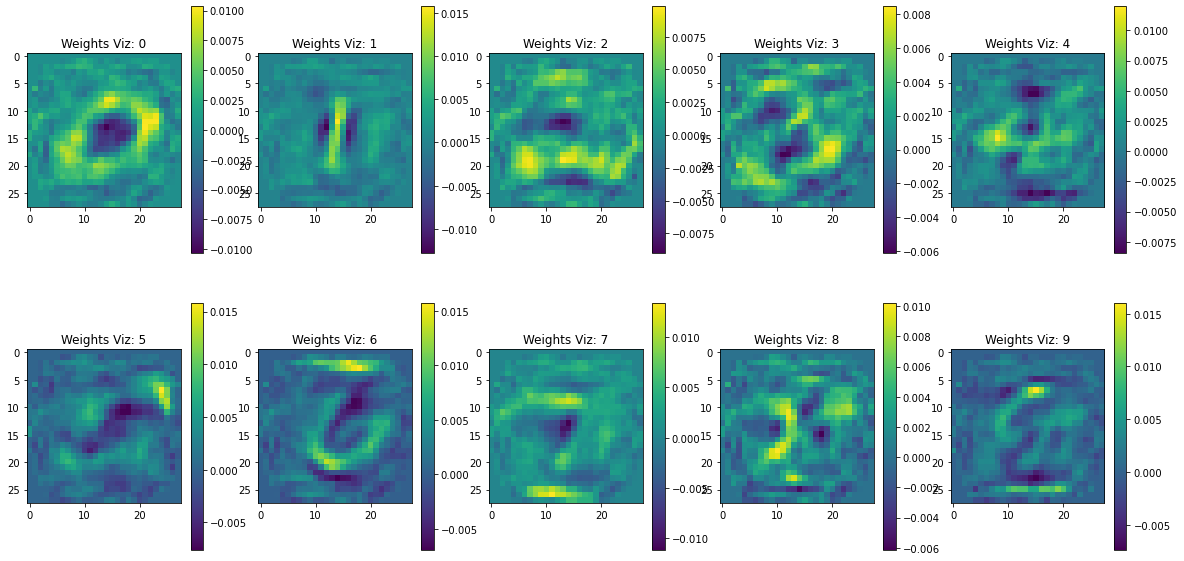

In [ ]:
#Visualize the weights of the best model for the Large dataset

w=model[best]

ind = 0
fig = plt.figure(figsize=(20,10))

for cn in class_names:
    plt.subplot(2,5,ind+1)
    plt.imshow(w[-28**2:, ind].reshape(28, 28))
    plt.title("Weights Viz: "+cn)
    plt.colorbar()
    ind += 1

plt.show()

## <span style="color:red">Question 1.2</span>
What do you observe about the visualized weights for each class label?

## <span style="color:red">Answer</span>
We can see that the visualization of the weights for each digit are, roughly, brighter in regions that you'd expect the digit to occupy. in particular for 0,1,3,6,7, and 9 we can even see vague outlines of the digits. The other digits have some as well but they are not as pronouced.

This is to be expected as it is precisely those regions that provide more evidence for that digit being the correct class.


### Visualize Confusion Matrix

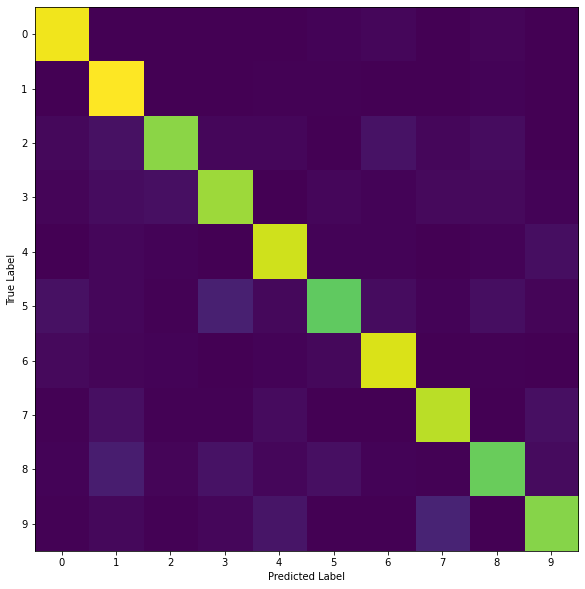

In [ ]:
# Visualize Confusion Matrix for best model
yVl_pred = np.argmax(infer(xVl, model[best]), axis=1)
conv_mat = build_confusion_matrix(yVl_pred, np.argmax(yVl, axis=1))

## <span style="color:red">Question 1.3</span>
What do you observe in the confusion matrix? 


## <span style="color:red">Answer</span>
As expected of a decently performing model, we see that the diagonals are brighter than any other region as it is those pixels that coorespond to correct classifications. Of the darker non diagonal region, brighter pixels coorespodn to common misclassifications. For example, pixel (x,y)=(3,5)  means that 3 is often confused for 5 which is intutive as they seem similar (at least compared to the other digits).


### Test via Kaggle Submission

In [ ]:
# Select the best model and use it to generate predictions for test data (to be submitted to Kaggle)
xTe = read_MNIST("testing")
xTe = preprocess_data(xTe, mu, sigma, visualize=False)


# Decide which model you want to use for your submission
chosen_model = model[best]

# Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe, chosen_model), axis=1)
create_submission_file("./large_submission.csv", final_preds)

## <span style="color:red">Question 1.4</span>
Report the result of your **best model** for Experiment 1
- train accuracy (from this experimentl)
- validation accuracy (from this experiment)
- test accuracy on private leaderboard (from Kaggle submission)
- test accuracy on public leaderboard (from Kaggle submission)


## <span style="color:red">Answer</span>
My model had the following:
- Train accuracy: 0.8546
- Val Accuracy: 0.8522
- Test private: N/A
- Test public: 0.86340

---
## Experiment 2: small training set
---
Now we will repeat this experiment with the small training set

## <span style="color:blue">**Coding 3.2**</span>
selection of the model based on a sweep over values of $\lambda$ (for small
datasets).

In [ ]:
xTr, yTr = read_MNIST("Training", load_small=True)
xVl, yVl = read_MNIST("Validation")
xTr, mu, sigma = preprocess_data(xTr, visualize=False)
xVl = preprocess_data(xVl, mu, sigma, visualize=False)

lambdas = [10.0]

sgd_opt = {"bsize": 3, "maxepochs": 100, "lr": 0.1, "verbose": 0}

seed = 0
set_seed(seed)

model, obj, trAcc, valAcc = tune_regularization(xTr, yTr, xVl, yVl, lambdas, sgd_opt)

# Add your code to select the best model for the small dataset
best=10

-------------- lambda=10.00000, val Acc = 0.5688  (tr Acc = 1.0000)


### Visualize Weight

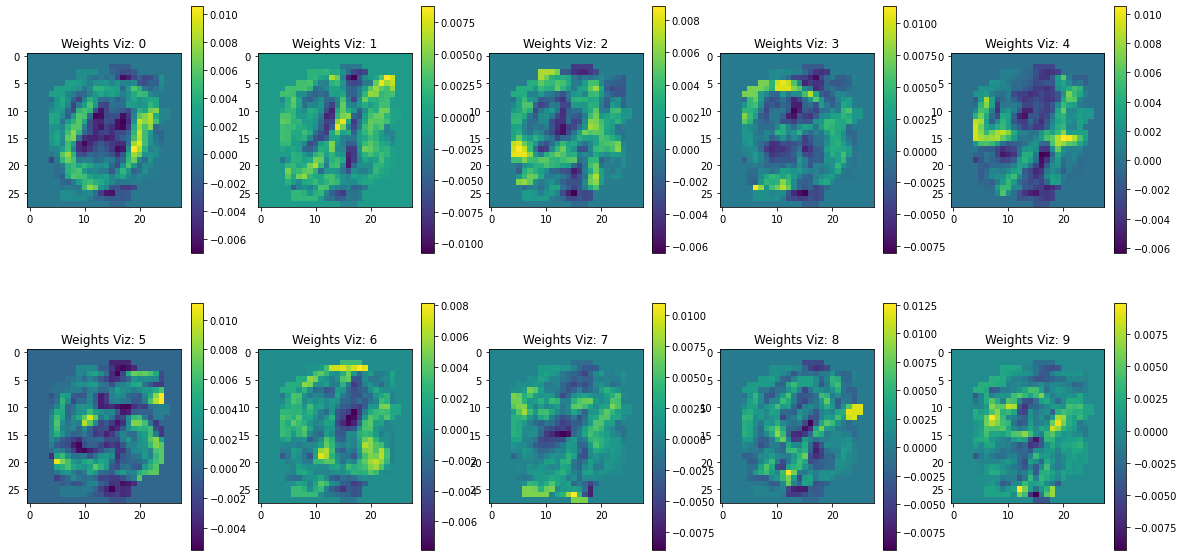

In [ ]:
# Visualize the weights of the best model for the small dataset

w = model[best]

ind = 0
fig = plt.figure(figsize=(20, 10))

for cn in class_names:
    plt.subplot(2, 5, ind + 1)
    plt.imshow(w[-(28 ** 2) :, ind].reshape(28, 28))
    plt.title("Weights Viz: " + cn)
    plt.colorbar()
    ind += 1

plt.show()

### Visualize Confusion Matrix

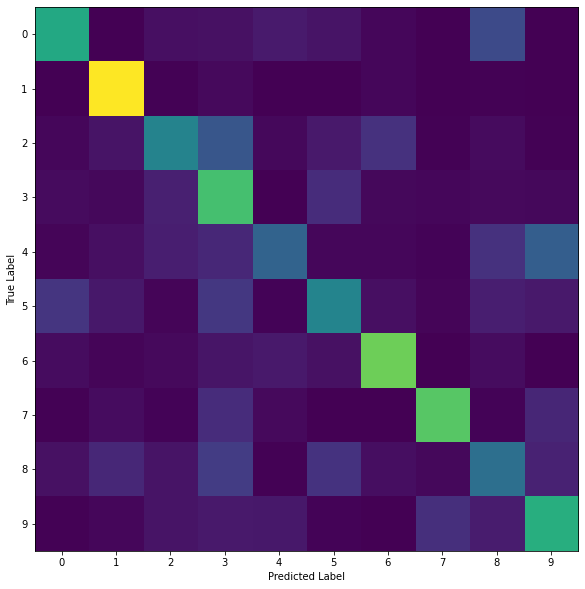

In [ ]:
# Visualize Confusion Matrix for best model for small dataset
yVl_pred = np.argmax(infer(xVl, model[best]), axis=1)
conv_mat = build_confusion_matrix(yVl_pred, np.argmax(yVl, axis=1))

## <span style="color:red">Question 2.1</span>
What do you observe about the *weight visualization* and *confusion matrix* **compared to the large training data** setting?

## <span style="color:red">Answer</span>
Weight Matrix: 
We can see that while the weight matrix still vaguly traces out shapes of the digits, it is not nearly as visible as it was with the large dataset. We still do see bright spots in the regions we'd want to have trained. For example, for 4 it seems too heavily biased on writing 4 in the way that doesn't connect the top.

Confusion Matrix:
While it is broadly the same we see that the diagonals are not as bright as in large dataset setting. conversly the darker region is not as dark in this confusion matrix. This cooresponds to more classification errors.



### Test via Kaggle Submission

In [ ]:
# Select the best model and use it to generate predictions for test data (to be submitted to Kaggle)
xTe = read_MNIST("testing")
xTe = preprocess_data(xTe, mu, sigma, visualize=False)


# Decide which model you want to use for your submission
chosen_model = model[best]

# Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe, chosen_model), axis=1)
create_submission_file("./small_submission.csv", final_preds)

## <span style="color:red">Question 2.2</span>
Report the result of your **best model** for Experiment 2
- train accuracy (from this experimentl)
- validation accuracy (from this experiment)
- test accuracy on private leaderboard (from Kaggle submission)
- test accuracy on public leaderboard (from Kaggle submission)


## <span style="color:red">Answer</span>
My model had the following:
- Train accuracy: 1
- Val Accuracy: 0.5701
- Test private: N/A
- Test public: 0.58199